RFBOutputContext()

JupyterWgpuCanvas(css_height='1024px', css_width='1024px')
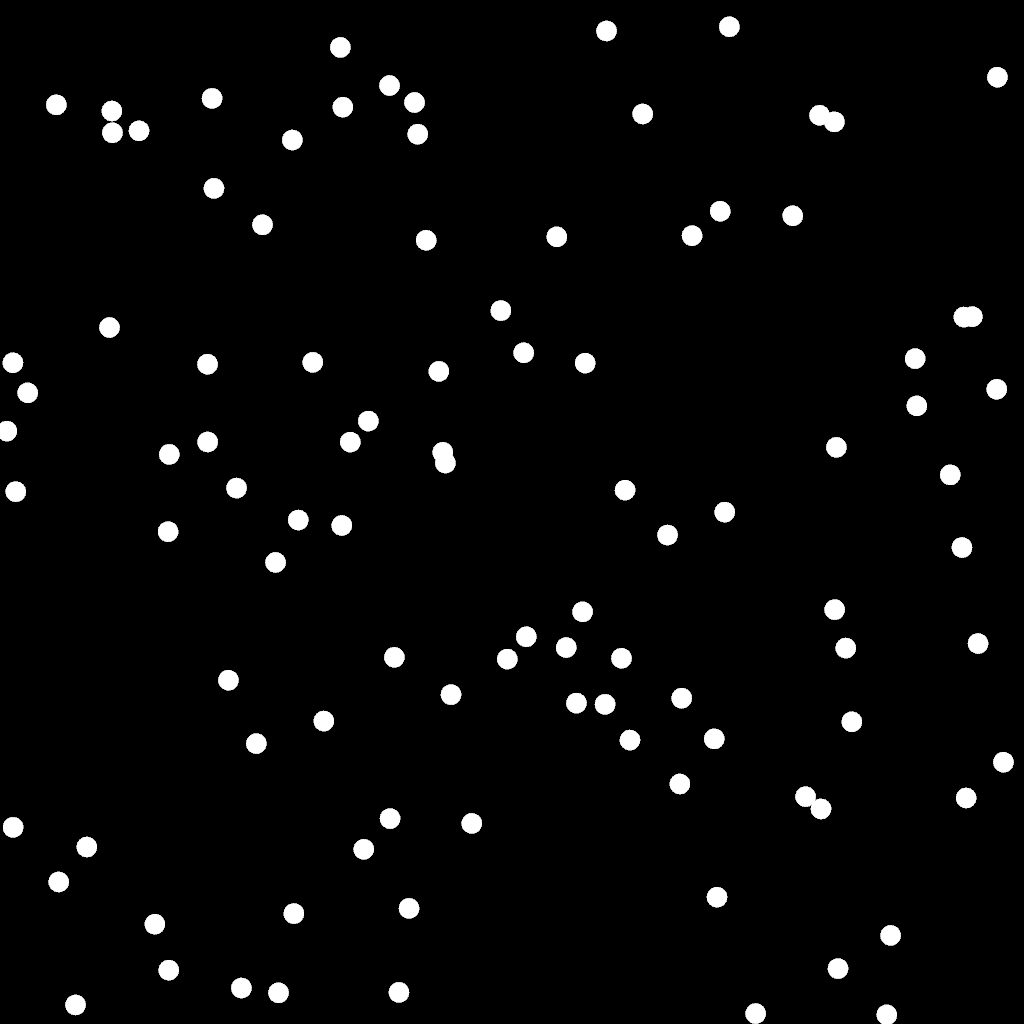

In [18]:
import wgpu
from wgpu.gui.auto import WgpuCanvas, run, call_later
import PIL.Image
import numpy as np

number_of_points = 100
point_resolution = 32
vertices = np.empty(shape=(point_resolution * number_of_points * 3, 2), dtype=np.float32)
window_width = 1024
window_height = 1024

class Simulation:
    def __init__(self):
        self.positions = (np.random.rand(number_of_points, 2) * 2 - 1)
        self.frame_count = 1
        
    def end_frame(self, image_array):
        image = PIL.Image.fromarray(image_array, mode="RGBA")
        image.save(f"frame-{self.frame_count}.png")

    def start_frame(self):
        self.positions *= 0.99
        if self.frame_count > 0:
            self.frame_count -= 1
            return self.positions
        return None

simulation = Simulation()

def setup_drawing(canvas, power_preference="high-performance"):
    adapter = wgpu.gpu.request_adapter_sync(power_preference=power_preference)
    device = adapter.request_device_sync(required_limits=None)
    context = canvas.get_context("wgpu")
    pipeline_kwargs = get_render_pipeline_kwargs(context, device)
    render_pipeline = device.create_render_pipeline(**pipeline_kwargs)
    
    vertex_buffer = device.create_buffer(size=len(vertices) * 2 * 4, usage=wgpu.BufferUsage.VERTEX + wgpu.BufferUsage.COPY_DST)
    vertex_buffer_staging = device.create_buffer(size=len(vertices) * 2 * 4, usage=wgpu.BufferUsage.MAP_WRITE + wgpu.BufferUsage.COPY_SRC)
    
    width_blocks = (window_width * 4 + 255) // 256 
    color_output_buffer = device.create_buffer(size=width_blocks* 256 * window_height, usage=wgpu.BufferUsage.COPY_DST + wgpu.BufferUsage.MAP_READ)

    color_texture = device.create_texture(
        format=context.get_preferred_format(device.adapter), 
        usage=wgpu.TextureUsage.RENDER_ATTACHMENT, 
        size={"width" :window_width, "height" :window_height}, 
        sample_count = 4
    )

    color_resolve_texture = device.create_texture(
        format=context.get_preferred_format(device.adapter), 
        usage=wgpu.TextureUsage.RENDER_ATTACHMENT + wgpu.TextureUsage.COPY_SRC, 
        size={"width" :window_width, "height" :window_height}, 
        sample_count = 1
    )

    present_multisampled_texture = device.create_texture(
        format=context.get_preferred_format(device.adapter), 
        usage=wgpu.TextureUsage.RENDER_ATTACHMENT, 
        size={"width" :window_width, "height" :window_height}, 
        sample_count = 4
    )
    
    return get_draw_function(
        canvas, 
        context, 
        device, 
        render_pipeline, 
        vertex_buffer, 
        vertex_buffer_staging, 
        color_output_buffer, 
        color_texture, 
        color_resolve_texture,
        present_multisampled_texture
    )


def get_render_pipeline_kwargs(context, device):
    context.configure(device=device, format=None)
    render_texture_format = context.get_preferred_format(device.adapter)
    shader = device.create_shader_module(code=shader_source)
    pipeline_layout = device.create_pipeline_layout(bind_group_layouts=[])
    
    return dict(
        layout=pipeline_layout,
        vertex={
            "buffers": [{
                "array_stride" : 8,
                "attributes" : [{
                    "format" : wgpu.VertexFormat.float32x2,
                    "offset" : 0,
                    "shader_location" : 0,
                }],
                "step_mode" : wgpu.VertexStepMode.vertex,
            }],
            "module": shader,
            "entry_point": "vs_main",
        },
        depth_stencil=None,
        multisample= {
            "count" :  4,
        },
        fragment={
            "module": shader,
            "entry_point": "fs_main",
            "targets": [
                {
                    "format": render_texture_format,
                    "blend": {
                        "color": {},
                        "alpha": {},
                    },
                },
                {
                    "format": render_texture_format,
                    "blend": {
                        "color": {},
                        "alpha": {},
                    },
                },
            ],
        },
    )


def get_draw_function(canvas, context, device, render_pipeline, vertex_buffer, 
                      vertex_buffer_staging, color_output_buffer, color_texture, color_resolve_texture, present_multisampled_texture):
    def draw_frame():
        positions = simulation.start_frame()
        if positions is None:
            return
        for i in range(number_of_points):
            for j in range(point_resolution):
                a = positions[i]
                b = positions[i] + np.array([np.cos(2*np.pi / point_resolution * j), np.sin(2*np.pi / point_resolution * j)]) * 0.02
                c = positions[i] + np.array([np.cos(2*np.pi / point_resolution * (j + 1)), np.sin(2*np.pi / point_resolution * (j + 1))]) * 0.02
                vertices[i * point_resolution * 3 + j * 3 + 0] = a
                vertices[i * point_resolution * 3 + j * 3 + 1] = b
                vertices[i * point_resolution * 3 + j * 3 + 2] = c
        vertex_buffer_staging.map_sync(wgpu.MapMode.WRITE)
        vertex_buffer_staging.write_mapped(vertices)
        vertex_buffer_staging.unmap()
        current_texture = context.get_current_texture()
        command_encoder = device.create_command_encoder()
        command_encoder.copy_buffer_to_buffer(
            source = vertex_buffer_staging,
            source_offset = 0,
            destination = vertex_buffer,
            destination_offset = 0,
            size = len(vertices) * 2 * 4
        )
        render_pass = command_encoder.begin_render_pass(
            color_attachments=[
                {
                    "view": present_multisampled_texture.create_view(),
                    "resolve_target": current_texture.create_view(),
                    "clear_value": (0, 0, 0, 1),
                    "load_op": wgpu.LoadOp.clear,
                    "store_op": wgpu.StoreOp.store,
                },
                {
                    "view": color_texture.create_view(),
                    "resolve_target": color_resolve_texture.create_view(),
                    "clear_value": (0, 0, 0, 1),
                    "load_op": wgpu.LoadOp.clear,
                    "store_op": wgpu.StoreOp.store,
                }
            ],
        )
        render_pass.set_pipeline(render_pipeline)
        render_pass.set_vertex_buffer(
            slot = 0,
            buffer = vertex_buffer,
            offset =  0,
            size = None
        )
        render_pass.draw(len(vertices), 1, 0, 0)
        render_pass.end()
        
        width_blocks = (window_width * 4 + 255) // 256
        command_encoder.copy_texture_to_buffer(
            {"aspect" : wgpu.TextureAspect.all, "mip_level" : 0, "origin" : {"x" : 0, "y" : 0, "z" : 0}, "texture" : color_resolve_texture}, 
            {"buffer" : color_output_buffer, "bytes_per_row" : width_blocks * 256, "offset" : 0}, 
            {"width" : current_texture.width, "height" : current_texture.height}
        )
        
        device.queue.submit([command_encoder.finish()])
        
        color_output_buffer.map_sync(wgpu.MapMode.READ)
        image_mem = color_output_buffer.read_mapped()
        color_output_buffer.unmap()
        padding = width_blocks * 256 - window_width * 4
        image_bytes_padded = np.frombuffer(image_mem.tobytes(), dtype=np.byte).reshape((window_height, window_width + padding, 4))
        image_array = image_bytes_padded[:,:window_width,:]
        simulation.end_frame(image_array)
        canvas.request_draw(draw_frame)
        
    return draw_frame

shader_source = """
struct VertexInput {
    @location(0) pos : vec2<f32>,
    @builtin(vertex_index) vertex_index : u32,
};
struct VertexOutput {
    @location(0) color     : vec4<f32>,
    @builtin(position) pos : vec4<f32>,
};

@vertex
fn vs_main(in: VertexInput) -> VertexOutput {
    let index = i32(in.vertex_index);
    var out: VertexOutput;
    out.pos = vec4<f32>(in.pos, 0.0, 1.0);
    out.color = vec4<f32>(1.0, 1.0, 1.0, 1.0);
    return out;
}

struct FragmentOutput {
    @location(0) present_color : vec4<f32>,   
    @location(1) save_color    : vec4<f32>,
};

@fragment
fn fs_main(in: VertexOutput) -> FragmentOutput {
    var out: FragmentOutput;
    let physical_color = pow(in.color.rgb, vec3<f32>(2.2));  // gamma correct
    out.present_color = vec4<f32>(physical_color, in.color.a);
    out.save_color = vec4<f32>(physical_color, in.color.a);
    return out;
}
"""


if __name__ == "__main__":
    canvas = WgpuCanvas(size=(window_width, window_height), title="cat")
    draw_frame = setup_drawing(canvas)
    canvas.request_draw(draw_frame)
    run()